In [1]:
%matplotlib inline
import pandas as pd, datetime as dt
import collections
import numpy as np
from sklearn import datasets, linear_model
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
import glob, os

## NOx vs CO2

In [2]:
files_lab = glob.glob('*C.xlsx')                                                   # read all VELA2 files
dic_lab = {}                                                                     # empty dictionary lab tests
                                                                    
CO2_TA = 179  # g/km, the type-approval for this Audi A1

i = 1
for each in files_lab:
    
    %time df = pd.read_excel(each, sheetname=1, header=0)                          # read the proper sheets within each file
    
    CO2 = df['c_CO2_Dil_g_vec\n[grams]']
    CO2_sum = CO2.sum()
    NOx = df['c_NOx_Dil_g_vec\n[grams]']
    NOx_sum = NOx.sum()
    
    v = df['DACtrl_ActualSpeed\n[kph]']            #group speed by intervals
    t_s = len(df.index)                                                #  time(s)
    t_h = t_s/3600                                                                    # time (hours)
    v_mean = v.mean()                                                  # speed means
    d = v_mean * t_h #b.reset_index(drop=True) * d.reset_index(drop=True)                # distance means
    
    CO2km = CO2_sum/d                                                    # CO2 per km 
    #CO2pct = CO2km*100/CO2_TA                                            # emissions as % of type approval (98 g/km)
    NOxkm = NOx_sum/d                                                    # NOx / km
    
    key = each.split('al_')[1].split('.x')[0]                             # shortening the titles of the files
    
    key = str(i) + "." + str(key)                                        # numbering the files
    dic_lab[key] = [CO2km , NOxkm]                                         # save means in the dictionary
    i = i+1

Wall time: 1.11 s
Wall time: 1.07 s
Wall time: 1.26 s
Wall time: 1.11 s
Wall time: 1.12 s
Wall time: 1.1 s
Wall time: 1.11 s
Wall time: 1.18 s
Wall time: 1.66 s
Wall time: 1.11 s
Wall time: 1.18 s
Wall time: 1.08 s
Wall time: 1.07 s
Wall time: 1.07 s
Wall time: 1.09 s
Wall time: 1.09 s


In [3]:
files_road = glob.glob('*[0-9].xlsx')                                         # read all EMROAD files
dic_road = {}                                                            # empty dictionary road test
#CO2_TA = 98  # g/km, the type-approval for this Audi A1

i = 1
for each in files_road:
    
    %time df = pd.read_excel(each, sheetname='TEST REPORT', header=6)

    df.rename(columns=lambda x: x.strip().replace(" ", "_"), inplace=True)   # convert the headers to read them: ' ' for '_'
    df.rename(columns=lambda x: x.strip().replace(".", "_"), inplace=True)   # convert the headers to read them: '.' for '_'
    
    
    CO2_COMP = df.COMPLETE_TEST['CO2'][1]      # g/km
    #CO2_COMP = CO2_COMP_*100/CO2_TA             # %
    CO2_URB = df.URBAN['CO2'][1]               # g/km
    #CO2_URB = CO2_URB_*100/CO2_TA               # %
    CO2_RUR = df.RURAL['CO2'][1]               # g/km
    #CO2_RUR = CO2_RUR_*100/CO2_TA               # %
    CO2_MOT = df.MOTORW_['CO2'][1]             # g/km
    #CO2_MOT = CO2_MOT_*100/CO2_TA               # %
    #CO2 = [CO2_COMP,CO2_URB,CO2_RUR,CO2_MOT]
    
    NOx_COMP = df.COMPLETE_TEST['NOx'][1]
    NOx_URB = df.URBAN['NOx'][1]
    NOx_RUR = df.RURAL['NOx'][1]
    NOx_MOT = df.MOTORW_['NOx'][1]

    #NOx = [NOx_COMP,NOx_URB,NOx_RUR,NOx_MOT]
    
    key = each.split('38_')[1].split('_E')[0]
    each = str(i) + "_" + str(each)
    dic_road[each] = [CO2_COMP,NOx_COMP,CO2_URB,NOx_URB,CO2_RUR,NOx_RUR,CO2_MOT,NOx_MOT]     # save means in the dictionary
    i = i+1

Wall time: 18.9 s
Wall time: 16 s
Wall time: 16.8 s
Wall time: 17.2 s


In [4]:
lab = pd.DataFrame()                                                          
lab = lab.from_dict(dic_lab, orient='index')                                  # convert dic to dataframe
lab['ind2'] = ['3','1','3','2','4','4','1','3',                            # proper order
               '4','4','1','3','2','4','3','4']
lab.columns = ['CO2_lab','NOx_lab','ind2']                                    # headers
lab['NOx_lab'] = lab['NOx_lab']*1000                                          # change unit to mg/km

In [5]:
lab = lab.sort_values('ind2')

lab['test'] = ['N_CD_23','N_CD_23','N_CD_23','N_+10%_CD_23',
              'N_+10%_CD_23','N_HT_23','N_HT_23','N_HT_23',
              'N_HT_23','N_HT_23','N_mod_HT_23','N_mod_HT_23',
              'N_mod_HT_23','N_mod_HT_23','N_mod_HT_23','N_mod_HT_23']

lab.columns = ['CO2_lab','NOx_lab','ind2','test']
lab

,CO2_lab,NOx_lab,ind2,test
2.NEDC_COLD_4WD_23°C,147.537185,107.404456,1,N_CD_23
7.NEDC_COLD_4WD_23°C,144.970983,91.760355,1,N_CD_23
11.NEDC_COLD_4WD_23°C,144.093839,95.026632,1,N_CD_23
4.NEDC +10%VELOC_COLD_4WD_23°C,154.677415,124.135103,2,N_+10%_CD_23
13.NEDC +10%VELOC_COLD_4WD_23°C,148.804844,146.052150,2,N_+10%_CD_23
1.NEDC_HOT_4WD_23°C,131.801099,97.651424,3,N_HT_23
3.NEDC_HOT_4WD_23°C,134.515472,117.147324,3,N_HT_23
8.NEDC_HOT_4WD_23°C,128.455904,184.416702,3,N_HT_23
12.NEDC_HOT_4WD_23°C,128.670890,222.104033,3,N_HT_23
15.NEDC_HOT_4WD_23°C,127.562589,188.542424,3,N_HT_23


In [6]:
name = lab.groupby(lab.ind2).mean()#.reset_index()#drop = True)
name['test'] = ['N_CD_23','N+10%_CD_23','N_HT_23','N_mod_HT_23']
                
name.columns = ['CO2_lab','NOx_lab','test']

name

,CO2_lab,NOx_lab,test
ind2,,,
1,145.534002,98.063814,N_CD_23
2,151.741130,135.093627,N+10%_CD_23
3,130.201191,161.972381,N_HT_23
4,119.959338,216.690174,N_mod_HT_23


In [7]:
road = pd.DataFrame()                               # convert dic to dataframe
road = road.from_dict(dic_road, orient='index')             # proper order
road['ALPH'] = ['a','b','c','d']              # indexing by letters
road.columns = ['CO2_COMP','NOx_COMP','CO2_URB','NOx_URB','CO2_RUR','NOx_RUR','CO2_MOT','NOx_MOT','ALPH']  # headers

road['NOx_COMP']=road['NOx_COMP']*1000                  # change unit to mg/km
road['NOx_URB']=road['NOx_URB']*1000                    # change unit to mg/km
road['NOx_RUR']=road['NOx_RUR']*1000                    # change unit to mg/km
road['NOx_MOT']=road['NOx_MOT']*1000                    # change unit to mg/km

road = road.sort_values('ALPH')
road

,CO2_COMP,NOx_COMP,CO2_URB,NOx_URB,CO2_RUR,NOx_RUR,CO2_MOT,NOx_MOT,ALPH
1_VW038_LAB_2017_06_09_EMROAD_Test1.xlsx,176.832481,765.498842,174.956991,599.109708,163.396875,889.540918,190.738855,846.616676,a
2_VW038_LAB_2017_06_12_EMROAD_Test2.xlsx,177.591966,698.572391,175.520953,501.832648,155.588896,782.870305,199.902071,851.637725,b
3_VW038_LAB_2017_06_13_EMROAD_Test3.xlsx,180.615271,856.803647,186.385211,682.292870,157.959137,835.332101,192.999642,1070.096323,c
4_VW038_LAB_2017_06_13_EMROAD_Test4.xlsx,175.967449,795.187202,172.764840,638.411325,150.122865,689.657236,202.995550,1073.893591,d


In [8]:
### Reshape index ###
r = road
r.index = r.index.str[8:11]
r

,CO2_COMP,NOx_COMP,CO2_URB,NOx_URB,CO2_RUR,NOx_RUR,CO2_MOT,NOx_MOT,ALPH
LAB,176.832481,765.498842,174.956991,599.109708,163.396875,889.540918,190.738855,846.616676,a
LAB,177.591966,698.572391,175.520953,501.832648,155.588896,782.870305,199.902071,851.637725,b
LAB,180.615271,856.803647,186.385211,682.292870,157.959137,835.332101,192.999642,1070.096323,c
LAB,175.967449,795.187202,172.764840,638.411325,150.122865,689.657236,202.995550,1073.893591,d


In [9]:
### Group by index and calculate means ###
r_avg = r.groupby(r.index).mean()#.reset_index()#drop = True)
#r_avg['test'] = ['ESP','LAB','MIL','SAC']
                
r_avg.columns = ['CO2_COMP','NOx_COMP','CO2_URB','NOx_URB','CO2_RUR','NOx_RUR','CO2_MOT','NOx_MOT']

r_avg[['CO2_COMP','NOx_COMP']]

,CO2_COMP,NOx_COMP
LAB,177.751792,779.01552


In [ ]:
road = pd.DataFrame()                               # convert dic to dataframe
road = road.from_dict(dic_road, orient='index')             # proper order
road['ALPH'] = ['a','b','c','d']              # indexing by letters
road.columns = ['CO2_COMP','NOx_COMP','CO2_URB','NOx_URB','CO2_RUR','NOx_RUR','CO2_MOT','NOx_MOT','ALPH']  # headers

road['NOx_COMP']=road['NOx_COMP']*1000                  # change unit to mg/km
road['NOx_URB']=road['NOx_URB']*1000                    # change unit to mg/km
road['NOx_RUR']=road['NOx_RUR']*1000                    # change unit to mg/km
road['NOx_MOT']=road['NOx_MOT']*1000                    # change unit to mg/km

road = road.sort_values('ALPH')
road

## Plot all tests

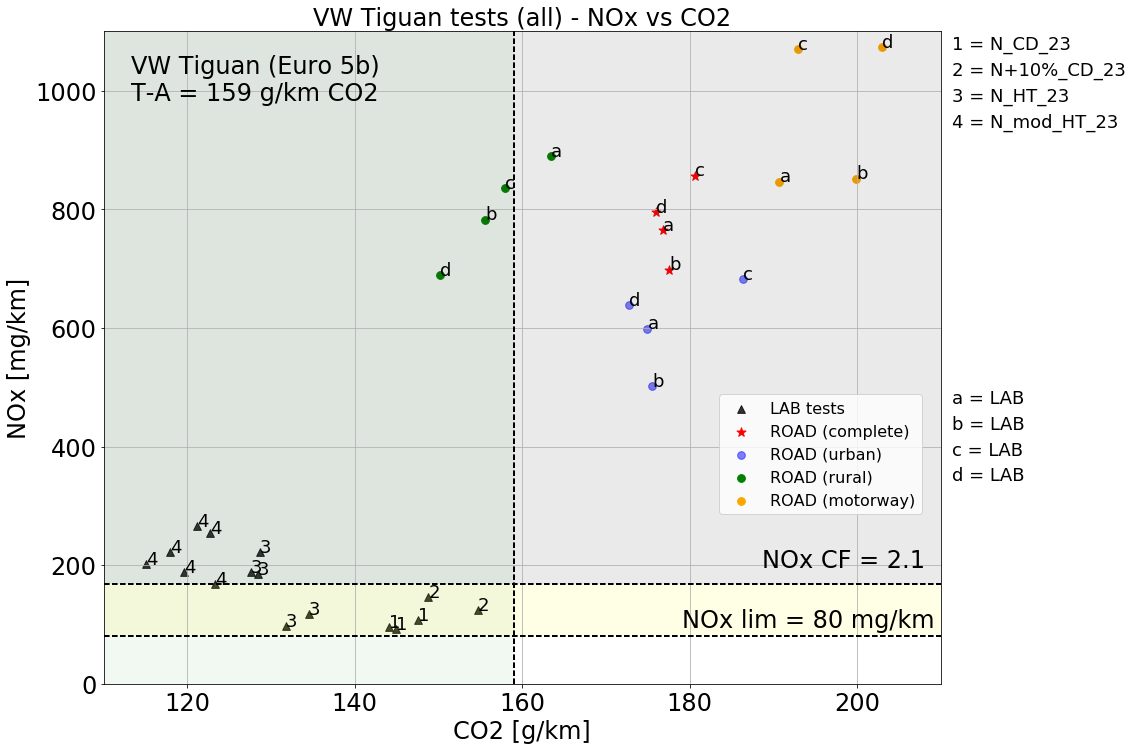

In [22]:
ax = lab.plot.scatter('CO2_lab', 'NOx_lab',marker='^', alpha=.8 ,s = 60, c = 'black', 
                      figsize = (15,12), grid ='on')
#plt.legend(lab.index, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#for ea in road.index:
road.plot.scatter('CO2_COMP','NOx_COMP', ax=ax, marker='*', s = 90, c = 'red', grid = 'on')
road.plot.scatter('CO2_URB','NOx_URB', ax=ax, s = 60, alpha=.5, c = 'blue', grid = 'on')
road.plot.scatter('CO2_RUR','NOx_RUR', ax=ax, s = 60, c = 'green', grid = 'on')
road.plot.scatter('CO2_MOT','NOx_MOT', ax=ax, s = 60, c = 'orange', grid = 'on')

legend = ('LAB tests','ROAD (complete)','ROAD (urban)','ROAD (rural)','ROAD (motorway)')
plt.legend(legend, fontsize = 16, loc = [0.735,0.26])

fontsize = 24
plt.ylabel('NOx [mg/km]', fontsize = fontsize)
plt.xlabel('CO2 [g/km]', fontsize = fontsize)
plt.xticks(fontsize = fontsize)
plt.yticks(fontsize = fontsize)
plt.title('VW Tiguan tests (all) - NOx vs CO2', fontsize = fontsize)
plt.axis([110,210,0,1100])

for i, txt in enumerate(lab.ind2):
    ax.annotate(txt, (lab.CO2_lab.iat[i],lab.NOx_lab.iat[i]), ha = 'left', fontsize = 18, clip_on=True) # change txt to i+1
        
for i, txt in enumerate(road.ALPH):
    ax.annotate(txt + '', (road.CO2_COMP.iat[i],road.NOx_COMP.iat[i]), ha = 'left', fontsize = 18, clip_on=True)
for i, txt in enumerate(road.ALPH):
    ax.annotate(txt + '', (road.CO2_URB.iat[i],road.NOx_URB.iat[i]), ha = 'left', fontsize = 18, clip_on=True)
for i, txt in enumerate(road.ALPH):
    ax.annotate(txt + '', (road.CO2_RUR.iat[i],road.NOx_RUR.iat[i]), ha = 'left', fontsize = 18, clip_on=True)
for i, txt in enumerate(road.ALPH):
    ax.annotate(txt + '', (road.CO2_MOT.iat[i],road.NOx_MOT.iat[i]), ha = 'left', fontsize = 18, clip_on=True)
    
i = 1
for each in name.test:
    plt.gcf().text(0.91, 0.89 - 0.03*i, str(i) + ' = ' +  each, fontsize=18)  
    i = i+1

i = 0
for each in road.index:
    plt.gcf().text(0.91, 0.45 - 0.03*i, road.ALPH[i] + ' = ' + each.split('038_')[1].split('_2017')[0] , fontsize=18)
    i = i+1
    
plt.gcf().text(0.15, 0.8 , str('VW Tiguan (Euro 5b) \nT-A = 159 g/km CO2'), fontsize=24)
plt.gcf().text(0.66, 0.19 , str('NOx lim = 80 mg/km'), fontsize=24)
plt.gcf().text(0.735, 0.26 , str('NOx CF = 2.1'), fontsize=24)

plt.axvline(x=159, color='k', linestyle='--', linewidth=2 )
plt.axhline(y=80, color='k', linestyle='--', linewidth=2 )
plt.axhline(y=80*2.1, color='k', linestyle='--', linewidth=2 )
plt.axhspan(80, 80*2.1, facecolor='yellow', alpha=0.1)
plt.axhspan(80*2.1, 1100, facecolor='0.2', alpha=0.1)
plt.axvspan(110, 159, facecolor='green', alpha=0.05)

## Plot avg. of repeated tests

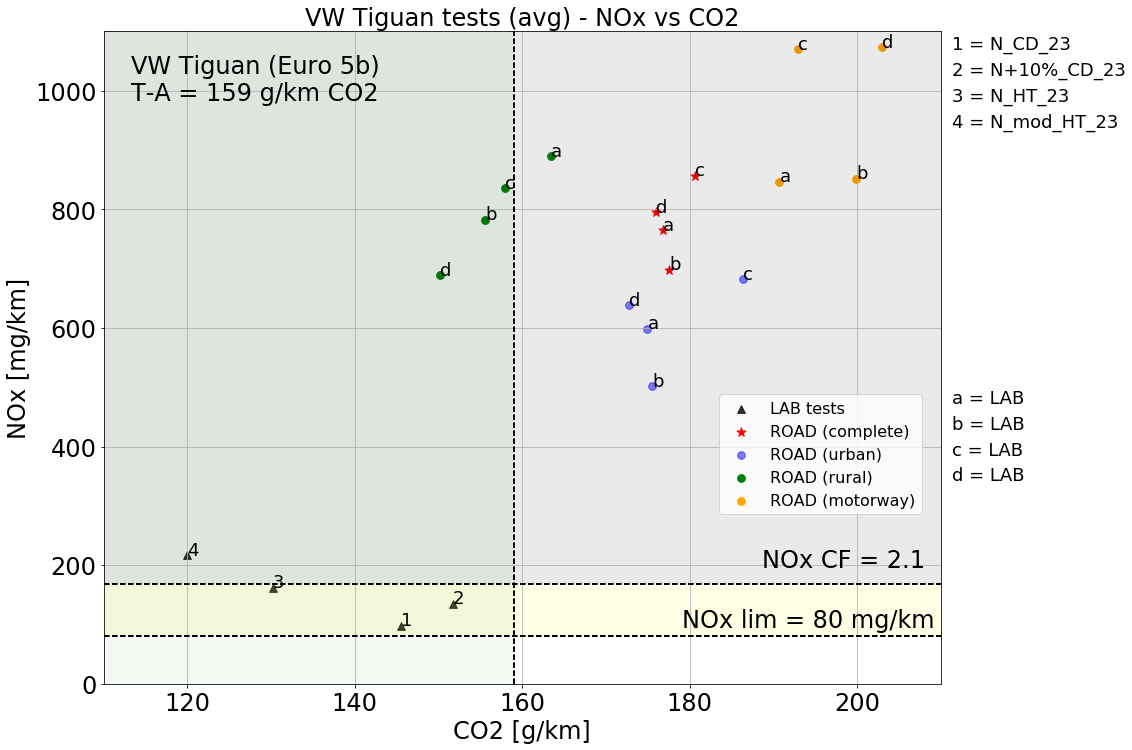

In [24]:
ax = name.plot.scatter('CO2_lab', 'NOx_lab',marker='^', alpha=.8 ,s = 60, c = 'black', 
                      figsize = (15,12), grid ='on')
#plt.legend(lab.index, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#for ea in road.index:
road.plot.scatter('CO2_COMP','NOx_COMP', ax=ax, marker='*', s = 90, c = 'red', grid = 'on')
road.plot.scatter('CO2_URB','NOx_URB', ax=ax, s = 60, alpha=.5, c = 'blue', grid = 'on')
road.plot.scatter('CO2_RUR','NOx_RUR', ax=ax, s = 60, c = 'green', grid = 'on')
road.plot.scatter('CO2_MOT','NOx_MOT', ax=ax, s = 60, c = 'orange', grid = 'on')

legend = ('LAB tests','ROAD (complete)','ROAD (urban)','ROAD (rural)','ROAD (motorway)')
plt.legend(legend, fontsize = 16, loc = [0.735,0.26])

fontsize = 24
plt.ylabel('NOx [mg/km]', fontsize = fontsize)
plt.xlabel('CO2 [g/km]', fontsize = fontsize)
plt.xticks(fontsize = fontsize)
plt.yticks(fontsize = fontsize)
plt.title('VW Tiguan tests (avg) - NOx vs CO2', fontsize = fontsize)
plt.axis([110,210,0,1100])

for i, txt in enumerate(name.test):
    ax.annotate(i+1, (name.CO2_lab.iat[i],name.NOx_lab.iat[i]), ha = 'left', fontsize = 18, clip_on=True) # change txt to i+1
        
for i, txt in enumerate(road.ALPH):
    ax.annotate(txt + '', (road.CO2_COMP.iat[i],road.NOx_COMP.iat[i]), ha = 'left', fontsize = 18, clip_on=True)
for i, txt in enumerate(road.ALPH):
    ax.annotate(txt + '', (road.CO2_URB.iat[i],road.NOx_URB.iat[i]), ha = 'left', fontsize = 18, clip_on=True)
for i, txt in enumerate(road.ALPH):
    ax.annotate(txt + '', (road.CO2_RUR.iat[i],road.NOx_RUR.iat[i]), ha = 'left', fontsize = 18, clip_on=True)
for i, txt in enumerate(road.ALPH):
    ax.annotate(txt + '', (road.CO2_MOT.iat[i],road.NOx_MOT.iat[i]), ha = 'left', fontsize = 18, clip_on=True)
    
i = 1
for each in name.test:
    plt.gcf().text(0.91, 0.89 - 0.03*i, str(i) + ' = ' +  each, fontsize=18)  
    i = i+1

i = 0
for each in road.index:
    plt.gcf().text(0.91, 0.45 - 0.03*i, road.ALPH[i] + ' = ' + each.split('038_')[1].split('_2017')[0] , fontsize=18)
    i = i+1
    
plt.gcf().text(0.15, 0.8 , str('VW Tiguan (Euro 5b) \nT-A = 159 g/km CO2'), fontsize=24)
plt.gcf().text(0.66, 0.19 , str('NOx lim = 80 mg/km'), fontsize=24)
plt.gcf().text(0.735, 0.26 , str('NOx CF = 2.1'), fontsize=24)

plt.axvline(x=159, color='k', linestyle='--', linewidth=2 )
plt.axhline(y=80, color='k', linestyle='--', linewidth=2 )
plt.axhline(y=80*2.1, color='k', linestyle='--', linewidth=2 )
plt.axhspan(80, 80*2.1, facecolor='yellow', alpha=0.1)
plt.axhspan(80*2.1, 1100, facecolor='0.2', alpha=0.1)
plt.axvspan(110, 159, facecolor='green', alpha=0.05)